# Face Recognition (GOOGLE COLAB)

In [1]:
!nvidia-smi

Fri Jun  5 16:29:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    25W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 2.x

In [3]:
!pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 3.2MB/s 


In [4]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.0


In [0]:
from keras.preprocessing import image as kimage
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization

# (Mount Google Drive from the menu on the left)

# Define Train/test/val sets

In [0]:
my_pictures_dir ="/content/drive/My Drive/2D/pictures_neutral_split"

In [0]:
train_dir = my_pictures_dir+"/train"
val_dir = my_pictures_dir+"/val"
test_dir = my_pictures_dir+"/test"

In [8]:
!ls "$my_pictures_dir/test"

alessandro  alinda  cami  gian	luca  mamma  papi  umbe


In [0]:
import matplotlib.pyplot as plt
import numpy as np

## Sample from test set

In [10]:
sample_processing = kimage.ImageDataGenerator()
sample_generator = sample_processing.flow_from_directory(train_dir,
                                                    classes=  ["alessandro", "alinda", "cami",  "gian", "mamma",  "papi"],
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=64,
                                                    class_mode="categorical",
                                                    shuffle=True,
                                                    seed=1)

Found 702 images belonging to 6 classes.


In [0]:
sample = sample_generator.next()
sample_features = sample[0]
sample_labels = sample[1]

In [12]:
labels_to_text = [i[0] for i in sample_generator.class_indices.items()]
labels_to_text

['alessandro', 'alinda', 'cami', 'gian', 'mamma', 'papi']

In [13]:
np.unique([labels_to_text[np.argmax(sample_labels[i])] for i in range(len(sample_labels))], return_counts=1)[1]

array([13, 13,  4, 17,  8,  9])

## Generators

In [0]:
train_processing = kimage.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    # rescale= 1./255,
    # Rotations
    rotation_range=10,
    # # Shifts
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # # Flips
    horizontal_flip=True,
    # vertical_flip=True,
    # Brightness Change
    brightness_range=[0.6,1.4],
    # Zoom Change
    zoom_range=[0.9,1.1]
    
)

In [0]:
train_processing.fit(sample_features)

In [16]:
train_processing.mean

array([[[119.39314 , 100.51132 ,  99.129295]]], dtype=float32)

In [17]:
train_generator = train_processing.flow_from_directory(train_dir,
                                                       classes=  ["alessandro", "alinda", "cami",  "gian", "mamma",  "papi"],
                                                       target_size=(224, 224),
                                                       color_mode="rgb",
                                                       batch_size=32,
                                                       class_mode="categorical",
                                                       shuffle=True,
                                                       seed=1)

Found 702 images belonging to 6 classes.


In [18]:
test_processing = kimage.ImageDataGenerator(featurewise_center=True,
                                            featurewise_std_normalization=True
                                            # rescale = 1./255
                                            )
test_processing.fit(sample_features)

val_generator = test_processing.flow_from_directory(val_dir,
                                                    classes=  ["alessandro", "alinda", "cami",  "gian", "mamma",  "papi"],
                                                    target_size=(224, 224),
                                                    color_mode="rgb",
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    shuffle=False,
                                                    seed=1)

test_generator = test_processing.flow_from_directory(test_dir,
                                                     classes=  ["alessandro", "alinda", "cami",  "gian", "mamma",  "papi"],
                                                     target_size=(224, 224),
                                                     color_mode="rgb",
                                                     batch_size=32,
                                                     class_mode="categorical",
                                                     shuffle=False,
                                                     seed=1)

Found 204 images belonging to 6 classes.
Found 102 images belonging to 6 classes.


In [19]:
n_classes = (train_generator.num_classes)
n_classes

6

### See preprocessed images

In [0]:
batch = np.array(train_generator.next()[0])

In [21]:
batch.shape

(32, 224, 224, 3)

In [0]:
mu = train_processing.mean
sigma = train_processing.std

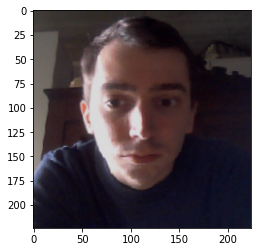

In [23]:
pic = batch[1]
plt.imshow((pic*sigma + mu)/255)
# plt.imshow(pic)
plt.show()

# Net

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
#create model
net = Sequential()
#add model layers
net.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(224,224,3)))
net.add(Conv2D(32, kernel_size=3, activation='relu'))
net.add(Flatten())
net.add(Dense(n_classes, activation='softmax'))

In [0]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=["accuracy"])


In [0]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         restore_best_weights=True, patience=5)

In [27]:
history = net.fit_generator(train_generator,
                  verbose=1,
                  epochs=30,
                  steps_per_epoch=train_generator.n//train_generator.batch_size,
                  callbacks=[callback],
                  validation_data=val_generator)

Epoch 1/30
21/21 [==============================] - 401s 19s/step - loss: 13.4760 - accuracy: 0.8254 - val_loss: 0.0000e+00 - val_accuracy: 0.9412
Epoch 2/30
21/21 [==============================] - 32s 2s/step - loss: 0.0065 - accuracy: 0.9970 - val_loss: 0.0000e+00 - val_accuracy: 0.9902
Epoch 3/30
21/21 [==============================] - 14s 652ms/step - loss: 0.2077 - accuracy: 0.9777 - val_loss: 0.0739 - val_accuracy: 0.9902
Epoch 4/30
21/21 [==============================] - 15s 693ms/step - loss: 2.8334 - accuracy: 0.9134 - val_loss: 0.0000e+00 - val_accuracy: 0.9902
Epoch 5/30
21/21 [==============================] - 15s 732ms/step - loss: 0.0237 - accuracy: 0.9925 - val_loss: 0.0000e+00 - val_accuracy: 0.9902
Epoch 6/30
21/21 [==============================] - 14s 655ms/step - loss: 0.0426 - accuracy: 0.9940 - val_loss: 0.0000e+00 - val_accuracy: 0.9902


# Save Model

In [0]:
import os

In [0]:
latest_model_number = max([int(e.split("_")[0]) for e in os.listdir("/content/drive/My Drive/2D/models/")])

In [0]:
model_name = latest_model_number + 1

In [36]:
model_filename = f"/content/drive/My Drive/2D/models/{model_name}_model.h5"
json_filename = f"/content/drive/My Drive/2D/models/{model_name}_model.json"
model_filename, json_filename

('/content/drive/My Drive/2D/models/12_model.h5',
 '/content/drive/My Drive/2D/models/12_model.json')

In [0]:
mu = list(train_processing.mean[0][0])
std = list(train_processing.std[0][0])

In [38]:
d = {}
d["mean"] = [str(i) for i in mu]
d["std"] = [str(i) for i in std]
d["model_n"] = model_name
d["featurewise_center"] = True
d["featurewise_std"] = True
d["class_indices"] = [i[0] for i in train_generator.class_indices.items()]

d

{'class_indices': ['alessandro', 'alinda', 'cami', 'gian', 'mamma', 'papi'],
 'featurewise_center': True,
 'featurewise_std': True,
 'mean': ['119.39314', '100.51132', '99.129295'],
 'model_n': 12,
 'std': ['62.04779', '59.544598', '59.233936']}

In [0]:
import json

In [0]:
with open(json_filename, "w") as jsonf:
    json.dump(d, jsonf)

In [0]:
net.save(model_filename)

## Evaluation


In [0]:
import numpy as np
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report

In [43]:
net.evaluate_generator(train_generator)

[0.0060929604806005955, 0.994301974773407]

In [44]:
net.evaluate_generator(val_generator)

[0.0, 0.9411764740943909]

In [45]:
net.evaluate_generator(test_generator)

[0.0, 0.9313725233078003]

In [0]:
def classification_report_generator(generator):
  # should not be applied to generators with shuffle = True
  preds = net.predict_generator(generator)
  preds = np.argmax(preds, axis=1)
  real = generator.classes
  ind_dict = generator.class_indices
  num_to_label = [i[0] for i in ind_dict.items()]
  cmat = cm(real, preds)
  cr = classification_report(real, preds, target_names=num_to_label)
  return cmat, cr

In [47]:
cm_val, cr_val = classification_report_generator(val_generator)
print(cr_val)

              precision    recall  f1-score   support

  alessandro       1.00      1.00      1.00        34
      alinda       1.00      0.94      0.97        34
        cami       1.00      0.71      0.83        34
        gian       1.00      1.00      1.00        34
       mamma       1.00      1.00      1.00        34
        papi       0.74      1.00      0.85        34

    accuracy                           0.94       204
   macro avg       0.96      0.94      0.94       204
weighted avg       0.96      0.94      0.94       204



In [48]:
cm_test, cr_test = classification_report_generator(test_generator)
print(cr_test)

              precision    recall  f1-score   support

  alessandro       1.00      1.00      1.00        17
      alinda       1.00      1.00      1.00        17
        cami       1.00      0.59      0.74        17
        gian       1.00      1.00      1.00        17
       mamma       1.00      1.00      1.00        17
        papi       0.71      1.00      0.83        17

    accuracy                           0.93       102
   macro avg       0.95      0.93      0.93       102
weighted avg       0.95      0.93      0.93       102



In [0]:
import matplotlib.pyplot as plt

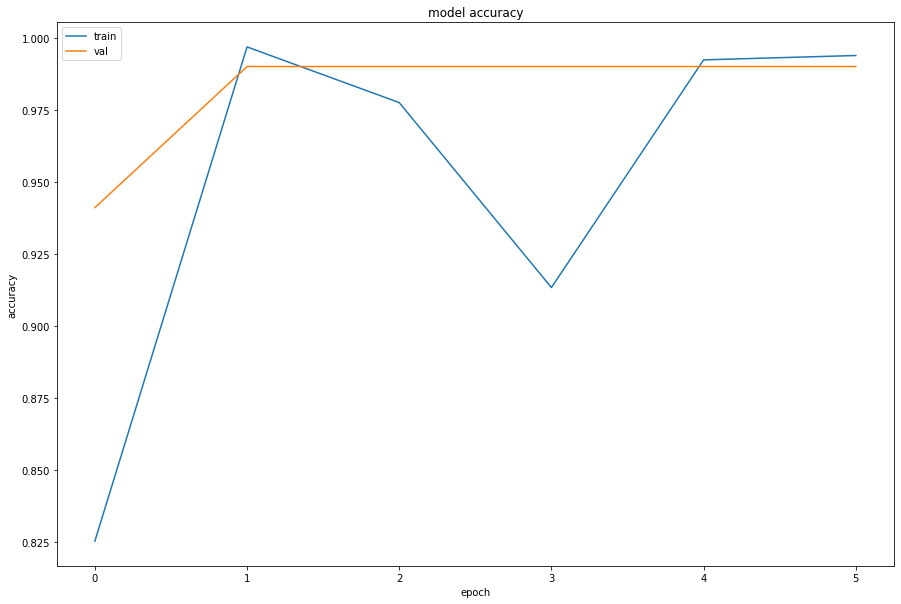

In [50]:
plt.figure(figsize=(15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

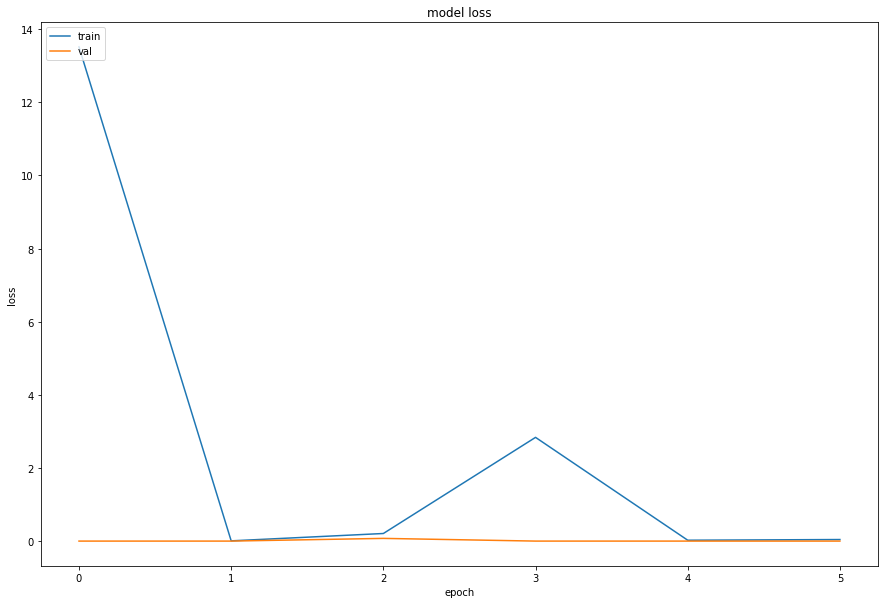

In [51]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# TODO

- Collect more data
- Choose a better model
- look at these: 
  - https://github.com/Golbstein/keras-face-recognition
  - https://github.com/krasserm/face-recognition